# Semantic Segmentation: Fluorescent Neuronal Cells 

## Setup

In [168]:
import os
import random

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from icecream import ic

import torch
from torch.utils.data import DataLoader

import albumentations as A

import pytorch_lightning as pl

from transformers import MobileViTForSemanticSegmentation, MobileViTImageProcessor, AutoImageProcessor
from datasets import Dataset, load_dataset
import evaluate

In [20]:
MODEL_CHECKPOINT = "apple/deeplabv3-mobilevit-small"
BATCH_SIZE = 8

# Define the accelerator
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps:0")
    ACCELERATOR = "mps"
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    ACCELERATOR = "gpu"
else:
    DEVICE = torch.device("cpu")
    ACCELERATOR = "cpu"

RAW_DATA_PATH = "../data/raw/"
DATA_PATH = "../data/processed/"



## Dataset

In [119]:
image_name = random.choice(os.listdir(os.path.join(RAW_DATA_PATH, "all_images", "images")))
image_path = os.path.join(RAW_DATA_PATH, "all_images", "images", image_name)
mask_path = os.path.join(RAW_DATA_PATH, "all_masks", "masks", image_name)

image = Image.open(image_path)
mask = Image.open(mask_path)


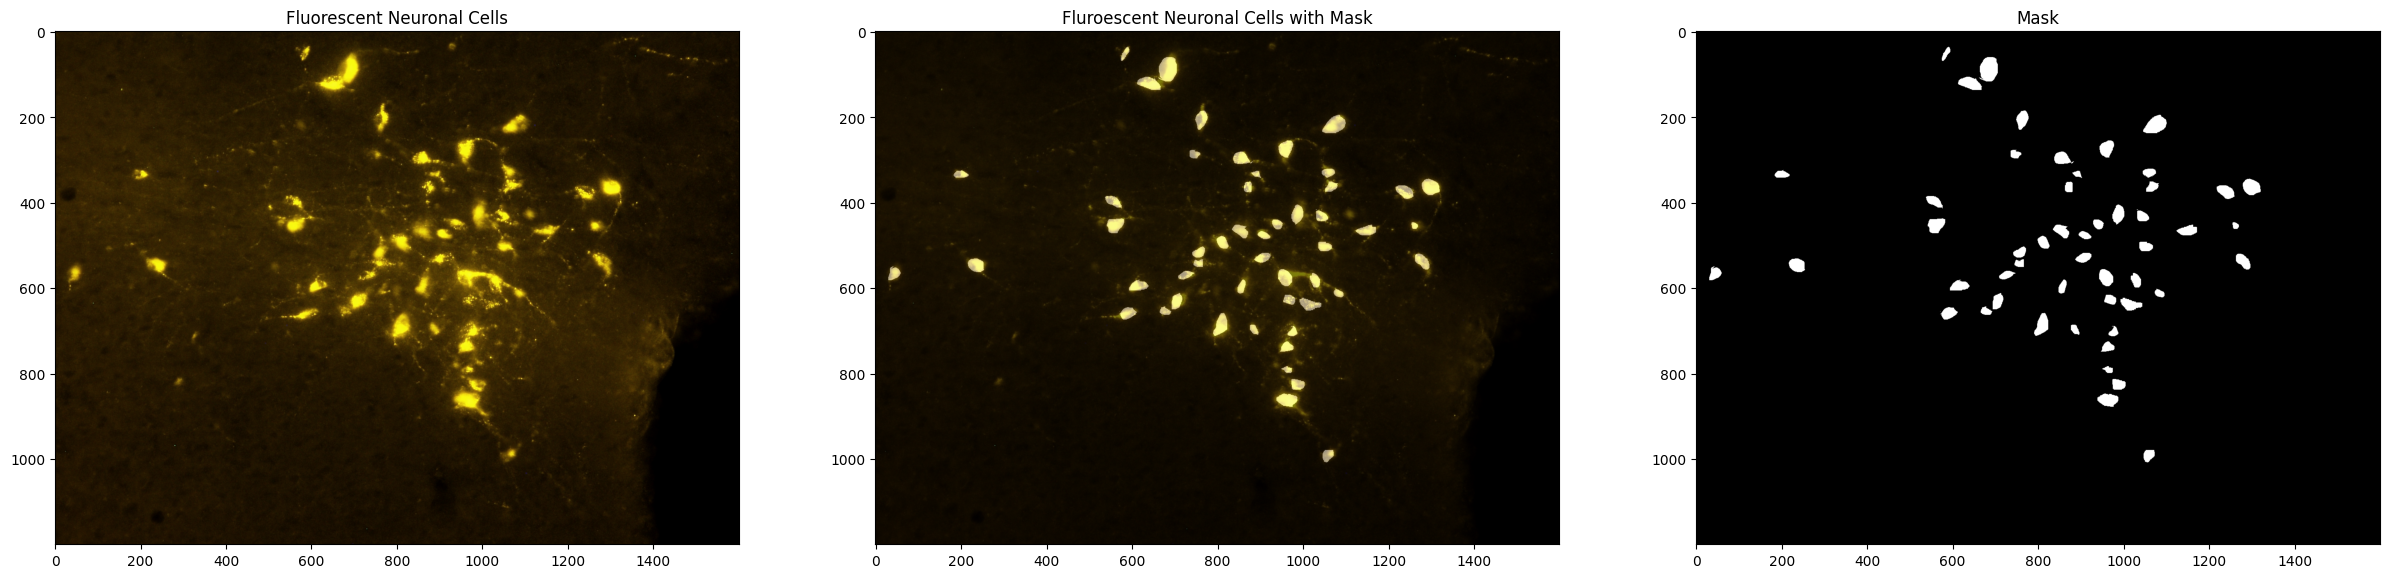

In [156]:
plt.figure(figsize=(30, 15))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Fluorescent Neuronal Cells")
plt.subplot(1, 3, 2)
plt.imshow(image)
plt.imshow(mask, cmap="viridis", alpha=0.5)
plt.title("Fluroescent Neuronal Cells with Mask")
plt.subplot(1, 3, 3)
plt.imshow(mask, cmap="inferno")
plt.title("Mask")
plt.show()

In [169]:
image_processor = AutoImageProcessor.from_pretrained(
    MODEL_CHECKPOINT, reduce_labels=True
)
inputs = image_processor(np.array(image), np.array(mask))
ic(inputs)

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 51a6b501-3c33-43ea-8653-ca283f172ef9)')' thrown while requesting HEAD https://huggingface.co/apple/deeplabv3-mobilevit-small/resolve/main/preprocessor_config.json
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


TypeError: BaseImageProcessor.__call__() takes 2 positional arguments but 3 were given

In [151]:
class FluorescentNeuronalDataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str = RAW_DATA_PATH) -> None:
        super().__init__()
        self.data_dir = data_dir
        self.image_processor = MobileViTImageProcessor.from_pretrained(
            MODEL_CHECKPOINT, reduce_labels=True
        )
        self.image_augmentator = A.Compose(
            [
                A.RandomBrightnessContrast(p=0.5),
                A.HueSaturationValue(p=0.5),
                A.HorizontalFlip(p=0.5),
            ]
        )

    def _create_dataset(self):
        images_path = os.path.join(self.data_dir, "all_images", "images")
        masks_path = os.path.join(self.data_dir, "all_masks", "masks")
        list_images = os.listdir(images_path)

        images = []
        masks = []
        for image_filename in list_images:
            image_path = os.path.join(images_path, image_filename)
            mask_path = os.path.join(masks_path, image_filename)

            image = np.array(Image.open(image_path).convert("RGB"))
            mask = np.array(Image.open(mask_path))

            images.append(image)
            masks.append(mask)

        dataset = Dataset.from_dict({"image": images, "mask": masks})
        return dataset

    def _transform_train_data(self, batch):
        images = [img for img in batch["image"]]
        masks = [mask for mask in batch["mask"]]
        aug_images = self.image_augmentator(image=images, mask=masks)
        inputs = self.image_processor(aug_images["image"], aug_images["mask"])
        return inputs

    def _transform_valid_data(self, batch):
        images = [img for img in batch["image"]]
        masks = [mask for mask in batch["mask"]]
        inputs = self.image_processor(images, masks)
        return inputs

    def setup(self, stage=None):
        dataset = self._create_dataset()
        dataset = dataset.train_test_split(test_size=0.3)
        train_ds = dataset["train"]
        valid_ds = dataset["test"]
        del dataset

        if stage is None or stage == "fit":
            self.train_ds = train_ds.set_transform(self._transform_train_data)
        if stage is None or stage == "test":
            self.valid_ds = valid_ds.set_transform(self._transform_valid_data)
    
    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=BATCH_SIZE, shuffle=True)
    
    def valid_dataloader(self):
        return DataLoader(self.valid_ds, batch_size=BATCH_SIZE)


In [152]:
data_module = FluorescentNeuronalDataModule()

## Create the Model

In [155]:
class MobileVit(pl.LightningModule):
    def __init__(self, learning_rate, weight_decay) -> None:
        super().__init__()
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.metric = evaluate.load("mean_iou")
        self.model = MobileViTForSemanticSegmentation.from_pretrained(MODEL_CHECKPOINT)

Compose([
  RandomBrightnessContrast(always_apply=False, p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True),
  HueSaturationValue(always_apply=False, p=0.5, hue_shift_limit=(-20, 20), sat_shift_limit=(-30, 30), val_shift_limit=(-20, 20)),
  HorizontalFlip(always_apply=False, p=0.5),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True)